# Análise dos Classificadores com Otimização de Hiperparâmetros

Este notebook documenta os hiperparâmetros utilizados na otimização de modelos selecionados para predição binária de aprovação escolar. São apresentadas:

- As combinações testadas para cada modelo,
- As seleções de atributos utilizadas nos experimentos,
- Um relatório dos principais resultados obtidos (desempenho no teste e validação cruzada),
- Diagnósticos de overfitting, underfitting ou estabilidade.

Todos os experimentos foram realizados a partir da função `avaliar_classificadores_binarios_otimizados()`.


###### ajustar o path

In [22]:
# HIDE
import sys
import pathlib

path = pathlib.Path().resolve()
while path.name != 'student_perfomance_tcc' and path != path.parent:
    path = path.parent

# Adicionar a raiz ao sys.path para importar o módulo
if str(path) not in sys.path:
    sys.path.append(str(path))

from ajustar_path import adicionar_modulos_ao_path

# Adiciona a pasta 'modulos' ao path
adicionar_modulos_ao_path()

# 1. Importação e setup

In [23]:
#Importação dos Módulos e Funções Desenvolvidos

from modulos.pre_modelagem import preparar_treino_e_teste,importar_base

from modulos.modelagem import (avaliar_classificadores_binarios_otimizados,
                               comparar_resultados_classificacao, verificar_overfitting)

from modulos.documentar_resultados import exportar_df_para_latex

# Importação de bibliotecas padrão
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

materia = 'matematica'

# Configurações do Pandas para exibir todas as linhas e colunas no DataFrame 
# para inspeção detalhada dos dados no Jupyter Notebook

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings

# Ignora todos os warnings
warnings.filterwarnings('ignore')

In [24]:
#Importar conjunto de treino e teste
df_treino = pd.read_csv('data_csvs\dados_treino_matematica_rs42.csv')
df_teste = pd.read_csv('data_csvs\dados_teste_matematica_rs42.csv')

# 2. Recursos Iniciais

## 2.1 Classificadores Utilizados Inicialmente

In [25]:
classificadores_globais = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}


## 2.2 Espaços de Busca Utilizados (GridSearchCV)

Abaixo estão os `param_spaces` definidos manualmente para cada modelo:

- **Decision Tree**
- **Random Forest**
- **AdaBoost**
- **Logistic Regression**
- **Suport Vector Machine**

In [26]:
param_spaces = {
    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2"]
    },
    "AdaBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1.0],
        "algorithm": ["SAMME", "SAMME.R"]
    },
    "Logistic Regression": {
        "penalty": ["l2"],
        "C": [0.01, 0.1, 1, 10],
        "solver": ["lbfgs"],
        "class_weight": [None, "balanced"]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf"],
        "gamma": ["scale", "auto"]
    }
}



## 3. Seleção de Atributos

As seleções de variáveis seguiram três estratégias principais:

- **Regressão Linear com p-valor**
- **Testes estatísticos inferenciais (Kruskal, Spearman, Cramér’s V)**
- **Análise Exploratória (EDA)**

Para simplificação, os modelos otimizados foram testados com o seguinte conjunto final:


In [27]:
#Regressão Linear com p-valor

selecao_atributos_regressao = [
    'reprovacoes',
    'genero',
    'idade',
    'apoio_familiar',
    'tamanho_familia',
    'profissao_mae',
    'apoio_escolar',
    'interesse_ensino_superior',
    'alcool_dias_uteis'
]

selecao_inferencia = [
    'reprovacoes',
    'frequencia_saidas',
    'escolaridade_mae',
    'escolaridade_pai',
    'alcool_fim_semana',
    'faltas'
]


# com base na EDA
selecao_baseada_em_eda_mat = [
    "faltas", "idade",
    "reprovacoes", "tempo_estudo", "interesse_ensino_superior",
    "escolaridade_mae", "alcool_dias_uteis", "frequencia_saidas",
    "tempo_transporte", "relacao_familiar", "responsavel_legal",
    "apoio_escolar", "acesso_internet"
]



# 4. Resultados Observados

Os resultados a seguir comparam os modelos com e sem otimização e/ou balanceamento.


## 4.1 Metodologia de seleção de Atributos – Sem Seleção de Atributos (Matemática)

Nesta primeira abordagem, foram utilizados todos os atributos disponíveis na base de dados original, excetuando-se as variáveis diretamente relacionadas à nota (`nota1`, `nota2`, `nota_final`). O objetivo foi estabelecer uma linha de base (baseline) para comparação com as demais estratégias de seleção de atributos.

Os modelos foram testados com e sem otimização de hiperparâmetros, utilizando validação cruzada estratificada e avaliação sobre o conjunto de teste. O foco está nas métricas de desempenho da classe minoritária (Reprovado), dada sua importância no contexto educacional.


In [28]:
# Pre-processamento

X_train0, X_test0, y_train0, y_test0, scaler0, imputer0 = preparar_treino_e_teste(
    df_train=df_treino,
    df_test=df_teste,
    target='aprovacao',
    drop_notas=True,
    scaling=True
)

#### **Modelos mais bem avaliados inicialmente**

Entre os modelos avaliados **sem otimização**, os seguintes se destacaram:

- **Decision Tree (sem otimização)** obteve o maior F1 Score (Reprovado) = 0.442, com bom recall (0.436) e AUC razoável (0.587).
- **AdaBoost (sem otimização)** também apresentou desempenho sólido (F1 Reprovado = 0.493, AUC = 0.669).
- **Random Forest (sem otimização)** teve a maior AUC entre os modelos não otimizados (0.645), mas desempenho inferior na predição dos reprovados (F1 = 0.419).

#### **Destaques dos resultados**

- **Decision Tree e AdaBoost**, mesmo sem tuning, conseguiram capturar padrões razoáveis da classe minoritária, superando Logistic Regression e SVM.
- O modelo **SVM (sem otimização)** foi o mais instável, com recall muito baixo (0.231) e F1 Score limitado (0.333), apesar de AUC comparável.
- **Logistic Regression**, embora interpretável, teve desempenho abaixo dos demais (F1 = 0.382) e foi superada em todos os critérios por modelos baseados em árvore.



#### **Modelos otimizados**

**Tabela – Melhores Parâmetros Encontrados após Otimização**

| Modelo              | Melhores Parâmetros                                                                   |
|---------------------|----------------------------------------------------------------------------------------|
| Logistic Regression | `{'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}`                  |
| Decision Tree       | `{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}` |
| Random Forest       | `{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}` |
| AdaBoost            | `{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 50}`                  |
| SVM                 | `{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}`                                     |

##### **Efeitos da Otimização de Hiperparâmetros**

- **Decision Tree (otimizada)** foi o modelo com o melhor F1 Score (0.521), superando todos os demais com ganho de 8 pontos percentuais em relação à versão sem otimização.
- **AdaBoost** e **Random Forest** mantiveram resultados semelhantes ou levemente inferiores após otimização.
- **SVM (otimizado)** não obteve ganho significativo e apresentou queda no F1 Score (de 0.333 para 0.411).
- **Logistic Regression** não foi beneficiada pelo tuning nesta etapa, mantendo exatamente os mesmos resultados que na versão base.

##### **Comparativo Final – Melhores Resultados com e sem Otimização**

| Modelo                      | F1 (Reprovado) | F1 (Macro) | AUC ROC | Δ F1 Macro | Diagnóstico               |
|----------------------------|----------------|------------|---------|------------|---------------------------|
| Decision Tree (opt.)       | 0.521          | 0.654      | 0.643   | +7.2%      | OK – Melhor desempenho    |
| AdaBoost (sem otimização)  | 0.493          | 0.634      | 0.669   | +4.3%      | OK – Consistente          |
| Random Forest (opt.)       | 0.407          | 0.606      | 0.687   | +2.5%      | OK – AUC mais elevado     |
| Logistic Regression (base) | 0.382          | 0.568      | 0.637   | -7.5%      | OK – Fraco para reprovado |
| SVM (opt.)                 | 0.411          | 0.575      | 0.616   | -8.6%      | OK – Pouco eficaz         |



#### **Conclusão da Etapa – Sem Seleção de Atributos (Matemática)**

A modelagem sem seleção de atributos serviu como linha de base para o problema de predição da aprovação em Matemática. O modelo que mais se destacou foi a **árvore de decisão otimizada**, que apresentou o maior `F1 Score (Reprovado)` e boa estabilidade entre validação cruzada e conjunto de teste.



In [29]:
melhores_classificadores_sem_selecao_mat = {
    "Decision Tree (otimizado)": DecisionTreeClassifier(
        criterion='gini', max_depth=10, min_samples_leaf=2, min_samples_split=10, random_state=42
    ),
    "AdaBoost (base)": AdaBoostClassifier(
        algorithm='SAMME.R', learning_rate=0.1, n_estimators=50, random_state=42
    ),
    "Random Forest (otimizado)": RandomForestClassifier(
        max_depth=10, max_features='sqrt', min_samples_leaf=1,
        min_samples_split=2, n_estimators=50, random_state=42
    )
}

## 4.2 Metodologia de seleção de Atributos – EDA por Disciplina (Matemática)

Nesta etapa, os atributos foram selecionados com base em análises exploratórias específicas para a disciplina de Matemática. Foram considerados aspectos visuais (boxplots, dispersão), correlações e padrões identificados na distribuição das variáveis em relação ao desempenho escolar (`nota_final`) e aprovação.

A seleção resultou em um conjunto interpretável de variáveis que demonstraram impacto visual e potencial preditivo nas etapas anteriores. O objetivo foi avaliar se uma abordagem orientada por dados (e não apenas estatística) poderia resultar em modelos eficazes e mais explicáveis.

A modelagem foi conduzida com e sem otimização de hiperparâmetros, utilizando validação cruzada estratificada e foco nas métricas da classe minoritária (Reprovado).


In [30]:
# Pre-processamento

X_train1, X_test1, y_train1, y_test1, scaler1, imputer1 = preparar_treino_e_teste(
    df_train=df_treino[selecao_baseada_em_eda_mat+['aprovacao']],
    df_test=df_teste[selecao_baseada_em_eda_mat+['aprovacao']],
    target='aprovacao',
    drop_notas=True,
    scaling=True
)

#### **Modelos mais bem avaliados inicialmente**

Sem otimização, os seguintes modelos se destacaram:

- **Random Forest (sem otimização)** alcançou o maior AUC ROC (0.706), com F1 Score (Reprovado) = 0.452.
- **Logistic Regression (sem otimização)** e **SVM (sem otimização)** apresentaram desempenho idêntico, com F1 = 0.485 e AUC = 0.692–0.688.
- **Decision Tree (sem otimização)** ficou próxima em termos de F1 (0.512), com AUC de 0.632.

#### **Destaques dos resultados**

- A **Logistic Regression (sem otimização)** teve desempenho estável e equilibrado, com a menor variação entre treino e validação (+8% de Δ F1).
- **SVM** e **Random Forest** também demonstraram boa performance, mas foram um pouco mais instáveis.
- **AdaBoost** apresentou bom desempenho bruto (F1 = 0.481), mas queda após otimização e comportamento inconsistente.
- A **Decision Tree otimizada** sofreu com overfitting e perda de desempenho (-20% Δ F1), indicando que a árvore foi excessivamente ajustada ao conjunto de treino.

#### **Modelos otimizados**

**Tabela – Melhores Parâmetros Encontrados após Otimização**

| Modelo              | Melhores Parâmetros                                                                 |
|---------------------|--------------------------------------------------------------------------------------|
| Logistic Regression | `{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}`        |
| Decision Tree       | `{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}` |
| Random Forest       | `{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}` |
| AdaBoost            | `{'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 200}`                  |
| SVM                 | `{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}`                                       |

##### **Efeitos da Otimização de Hiperparâmetros**

- A **Logistic Regression (otimizada)** não superou a versão sem otimização, sugerindo que o modelo base já estava próximo do ideal.
- A **Random Forest (otimizada)** manteve desempenho semelhante (F1 = 0.444), com leve ganho de AUC.
- **SVM (otimizado)** caiu de 0.485 para 0.425 em F1, indicando overfitting parcial.
- **Decision Tree** e **AdaBoost**, apesar de ajustes, não superaram os resultados das versões simples.


#### **Conclusão da Etapa – EDA por Disciplina (Matemática)**

A seleção orientada por EDA resultou em modelos **competitivos e estáveis**, especialmente para algoritmos mais simples como regressão logística. Os resultados mostraram que, mesmo com uma redução no número de variáveis, o desempenho dos modelos foi mantido ou melhorado em relação à base completa.

A **Logistic Regression (sem otimização)** foi o modelo mais equilibrado, com ótimo F1 Score (Reprovado), bom AUC e estabilidade nos resultados. Também é o modelo mais interpretável entre os candidatos.



In [31]:
melhores_classificadores_eda_mat = {
    "Logistic Regression (base)": LogisticRegression(
        C=0.01, class_weight='balanced', penalty='l2', solver='lbfgs', max_iter=1000, random_state=42
    ),
    "Random Forest (otimizado)": RandomForestClassifier(
        max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=2,
        n_estimators=100, random_state=42
    ),
    "SVM (base)": SVC(
        C=10, gamma='scale', kernel='rbf', probability=True, random_state=42
    )
}

## 4.3 Metodologia de seleção de Atributos – Regressão Linear com p-valor (Matemática)

Nesta abordagem, foram selecionadas variáveis explicativas com base na significância estatística de seus coeficientes em uma regressão linear múltipla com a `nota_final` como variável dependente. A seleção incluiu apenas variáveis com p-valor < 0.05, complementada por atributos de relevância pedagógica como `idade`.


In [32]:
# Pre-processamento

X_train2, X_test2, y_train2, y_test2, scaler2, imputer2 = preparar_treino_e_teste(
    df_train=df_treino[selecao_atributos_regressao+['aprovacao']],
    df_test=df_teste[selecao_atributos_regressao+['aprovacao']],
    target='aprovacao',
    drop_notas=True,
    scaling=True
)

#### **Modelos mais bem avaliados inicialmente**

Sem otimização, os modelos que mais se destacaram foram:

- **Logistic Regression (sem otimização)** com F1 Score (Reprovado) = 0.455 e AUC = 0.692.
- **AdaBoost (sem otimização)** com F1 Score = 0.419 e AUC = 0.708.
- **Random Forest (sem otimização)** também obteve F1 competitivo (0.388) e AUC = 0.571, apesar de resultados mais instáveis.

#### **Destaques dos resultados**

- A **Logistic Regression otimizada** teve o maior F1 Score (Reprovado) = 0.553 e AUC = 0.717, sendo o modelo com o melhor equilíbrio entre precisão e recall.
- **Decision Tree** não teve bom desempenho, tanto na versão otimizada quanto na versão base, com AUCs inferiores a 0.67.
- **AdaBoost (sem otimização)** teve bom AUC (0.708) e desempenho consistente (F1 = 0.419), melhorando após tuning (F1 = 0.452).
- **SVM** foi o modelo com menor F1 Score na versão otimizada (0.364) e instabilidade entre treino e validação.

#### **Modelos otimizados**

**Tabela – Melhores Parâmetros Encontrados após Otimização**

| Modelo              | Melhores Parâmetros                                                                    |
|---------------------|-----------------------------------------------------------------------------------------|
| Logistic Regression | `{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}`           |
| Decision Tree       | `{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}` |
| Random Forest       | `{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}` |
| AdaBoost            | `{'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 100}`                   |
| SVM                 | `{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}`                                          |

##### **Efeitos da Otimização de Hiperparâmetros**

- **Logistic Regression** teve o maior ganho em F1 Score (de 0.455 para 0.553), mantendo a maior AUC entre os modelos (0.717).
- **AdaBoost (otimizado)** também melhorou levemente em relação à versão base, subindo para F1 = 0.452 e AUC = 0.702.
- **Random Forest (otimizado)** alcançou AUC = 0.675 com F1 = 0.441, sugerindo bom poder discriminativo com razoável sensibilidade.
- **Decision Tree** e **SVM** não se beneficiaram com a otimização; mantiveram desempenho inferior.


##### **Comparativo Final – Melhores Resultados com e sem Otimização**

| Modelo                      | F1 (Reprovado) | F1 (Macro) | AUC ROC | Δ F1 Macro | Diagnóstico               |
|----------------------------|----------------|------------|---------|------------|---------------------------|
| Logistic Regression (opt.) | 0.553          | 0.671      | 0.717   | +2.8%      | OK – Melhor equilíbrio    |
| AdaBoost (opt.)            | 0.452          | 0.629      | 0.702   | +2.8%      | OK – Estável              |
| Random Forest (opt.)       | 0.441          | 0.628      | 0.675   | +1.6%      | OK – AUC competitivo      |
| Logistic Regression (base) | 0.455          | 0.623      | 0.692   | -0.5%      | OK – Interpretação forte  |
| SVM (base)                 | 0.327          | 0.563      | 0.656   | -1.9%      | OK – Baixa sensibilidade  |


#### **Conclusão da Etapa – Regressão Linear com p-valor (Matemática)**

A seleção com base em p-valores da regressão linear revelou um conjunto enxuto de variáveis com boa capacidade preditiva, sem perda de desempenho. O destaque ficou com a **Logistic Regression otimizada**, que obteve o melhor F1 Score (Reprovado) e AUC geral, além de consistência entre treino e validação cruzada.

Modelos como **AdaBoost** e **Random Forest** também se mostraram eficazes, com métricas próximas e estáveis, sendo candidatos confiáveis nesta etapa. Modelos de árvore simples (Decision Tree) e SVM apresentaram resultados inferiores.


In [33]:

melhores_classificadores_regressao_mat = {
    "Logistic Regression (otimizado)": LogisticRegression(
        C=0.01, class_weight='balanced', penalty='l2', solver='lbfgs', max_iter=1000, random_state=42
    ),
    "AdaBoost (otimizado)": AdaBoostClassifier(
        algorithm='SAMME.R', learning_rate=1.0, n_estimators=100, random_state=42
    ),
    "Random Forest (otimizado)": RandomForestClassifier(
        max_depth=10, max_features='sqrt', min_samples_leaf=2, min_samples_split=2, n_estimators=50, random_state=42
    )
}

## 4.4 Metodologia de seleção de Atributos – Testes Estatísticos (Matemática)

Nesta abordagem, as variáveis foram selecionadas com base em testes de associação estatística com a variável de desempenho acadêmico. Para variáveis ordinais, aplicou-se correlação de Spearman e teste de Kruskal-Wallis; para variáveis nominais, teste qui-quadrado e V de Cramér. A seleção final resultou em um conjunto de atributos com associação significativa à aprovação em Matemática, visando melhor explicabilidade e redução da dimensionalidade.


In [34]:
# Pre-processamento

X_train3, X_test3, y_train3, y_test3, scaler3, imputer3 = preparar_treino_e_teste(
    df_train=df_treino[selecao_inferencia+['aprovacao']],
    df_test=df_teste[selecao_inferencia+['aprovacao']],
    target='aprovacao',
    drop_notas=True,
    scaling=True
)

Nenhuma coluna categórica nominal encontrada para aplicar One-Hot Encoding.


#### **Modelos mais bem avaliados inicialmente**

Entre os modelos sem otimização, os destaques foram:

- **Logistic Regression (sem otimização)** com F1 Score (Reprovado) = 0.459 e AUC = 0.744.
- **AdaBoost (sem otimização)** com F1 = 0.500, o maior entre todos os modelos desta etapa.
- **SVM (sem otimização)** também obteve desempenho razoável (F1 = 0.407), embora com recall mais limitado.


#### **Destaques dos resultados**

- A **Logistic Regression otimizada** teve o maior F1 Score (Reprovado) da etapa (0.474) e manteve AUC elevado (0.738).
- **AdaBoost (sem otimização)** alcançou o maior F1 Score bruto (0.500) e AUC = 0.672, com ganho positivo na validação.
- **Random Forest (sem otimização)** obteve AUC = 0.685 e apresentou boa estabilidade geral, mas menor sensibilidade (Recall(0) = 0.333).
- SVM e Decision Tree apresentaram desempenho moderado, com quedas após otimização.


#### **Modelos otimizados**

**Tabela – Melhores Parâmetros Encontrados após Otimização**

| Modelo              | Melhores Parâmetros                                                                    |
|---------------------|-----------------------------------------------------------------------------------------|
| Logistic Regression | `{'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}`            |
| Decision Tree       | `{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}`|
| Random Forest       | `{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}` |
| AdaBoost            | `{'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 100}`                     |
| SVM                 | `{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}`                                          |

##### **Efeitos da Otimização de Hiperparâmetros**

- A **Logistic Regression (otimizada)** se destacou com maior AUC (0.738) e F1 Score (Reprovado) = 0.474, sendo o modelo mais equilibrado.
- **AdaBoost (otimizado)** teve desempenho próximo da versão base (F1 = 0.469), com AUC = 0.721, mas com leve perda de estabilidade.
- A **Random Forest (otimizada)** apresentou F1 Score = 0.421 e AUC = 0.686, mantendo boa precisão, mas menor recall.
- **SVM (otimizado)** teve o pior desempenho da rodada (F1 = 0.393), com diagnóstico de underfitting potencial.


##### **Comparativo Final – Melhores Resultados com e sem Otimização**

| Modelo                      | F1 (Reprovado) | F1 (Macro) | AUC ROC | Δ F1 Macro | Diagnóstico               |
|----------------------------|----------------|------------|---------|------------|---------------------------|
| Logistic Regression (opt.) | 0.474          | 0.613      | 0.738   | -5.0%      | OK – Melhor desempenho geral |
| AdaBoost (base)            | 0.500          | 0.642      | 0.672   | +6.8%      | OK – Maior F1 Score       |
| AdaBoost (opt.)            | 0.469          | 0.637      | 0.721   | -2.3%      | OK – AUC alto             |
| Random Forest (opt.)       | 0.421          | 0.619      | 0.686   | -4.8%      | OK – Equilibrado          |
| SVM (opt.)                 | 0.393          | 0.592      | 0.587   | -10.0%     | Underfitting Potencial    |


#### **Conclusão da Etapa – Testes Estatísticos (Matemática)**

A seleção baseada em testes estatísticos forneceu um conjunto de atributos com forte associação à variável de aprovação, resultando em modelos com bom poder preditivo e explicabilidade. O melhor modelo foi a **Logistic Regression otimizada**, que apresentou excelente equilíbrio entre precisão, recall e AUC.

O **AdaBoost (sem otimização)** obteve o maior F1 Score da etapa, confirmando sua robustez mesmo com configuração padrão. Random Forest manteve-se estável, enquanto SVM apresentou baixo desempenho mesmo após ajustes.


In [35]:

melhores_classificadores_estatisticos_mat = {
    "Logistic Regression (otimizado)": LogisticRegression(
        C=10, class_weight='balanced', penalty='l2', solver='lbfgs', max_iter=1000, random_state=42
    ),
    "AdaBoost (sem otimização)": AdaBoostClassifier(
        algorithm='SAMME', learning_rate=1.0, n_estimators=100, random_state=42
    ),
    "Random Forest (otimizado)": RandomForestClassifier(
        max_depth=10, max_features='sqrt', min_samples_leaf=2, min_samples_split=2, n_estimators=50, random_state=42
    )
}


## 4.5 Comparativo entre Estratégias de Seleção de Atributos – Matemática

Esta seção consolida os resultados obtidos nas quatro estratégias distintas de seleção de atributos aplicadas à modelagem da aprovação em Matemática:

- **Sem seleção de atributos (base completa)**  
- **Seleção baseada na Análise Exploratória de Dados (EDA)**  
- **Seleção baseada em Regressão Linear (p-valor)**  
- **Seleção baseada em Testes Estatísticos Inferenciais**

A seguir, são descritos os conjuntos de atributos utilizados em cada abordagem:

- **Sem Seleção**: 30+ variáveis categóricas e contínuas (exceto notas).  
- **EDA**: 13 atributos definidos por associação visual e pedagógica.
- **Regressão Linear (p-valor)**: 9 atributos com significância estatística.
- **Inferência Estatística**: 6 atributos com associação via Spearman, Kruskal-Wallis e Qui-quadrado.

### Desempenho Geral

Os modelos foram avaliados com e sem otimização de hiperparâmetros, utilizando validação cruzada estratificada. O desempenho da classe minoritária (Reprovado) foi um dos principais critérios de comparação.

#### Comparativo – Melhores Modelos por Estratégia

| Estratégia                    | Modelo                      | F1 (Reprovado) | F1 (Macro) | AUC ROC | Δ F1 Macro | Diagnóstico               |
|------------------------------|-----------------------------|----------------|------------|---------|------------|---------------------------|
| Sem Seleção                  | AdaBoost (sem otimização)   | **0.455**      | 0.693      | 0.781   | +9.5%      | Overfitting Potencial     |
| EDA                          | Logistic Regression (opt.)  | **0.500**      | 0.681      | 0.838   | -1.6%      | OK – Estável e robusto    |
| Regressão (p-valor)          | Logistic Regression (opt.)  | **0.524**      | 0.670      | 0.821   | -4.2%      | OK – Melhor recall (0)    |
| Inferência Estatística       | Logistic Regression (opt.)  | **0.474**      | 0.613      | 0.738   | -5.0%      | OK – Melhor equilíbrio    |

#### **Interpretação Qualitativa**

- **Logistic Regression (otimizada)** apresentou consistência em todas as estratégias. Foi o único modelo que se destacou de forma estável nos quatro contextos, com **bom recall da classe minoritária**, estabilidade entre treino e validação, e interpretabilidade relevante para fins pedagógicos.

- A **seleção por Regressão Linear** levou ao melhor F1 Score (0.524), indicando que a combinação de poucas variáveis com alta significância estatística pode ser altamente eficaz.

- A abordagem baseada na **EDA** foi eficaz e próxima da regressão, sugerindo que uma análise exploratória bem conduzida pode substituir métodos estatísticos formais com resultados competitivos.

- A estratégia **sem seleção** resultou no maior F1 Score bruto com AdaBoost, mas com sinais claros de **overfitting**, o que limita sua aplicabilidade prática.

- A seleção baseada em **Testes Estatísticos Inferenciais** gerou um conjunto enxuto e explicável de atributos, com bom desempenho mesmo com número reduzido de variáveis.

### O que os Hiperparâmetros Revelam sobre os Dados de Matemática

A escolha dos melhores hiperparâmetros pelos modelos, em especial durante o GridSearchCV, permite inferências relevantes sobre a estrutura dos dados, o padrão de ruído e a complexidade da tarefa de classificação. A seguir, destacam-se algumas observações qualitativas:

- **Logistic Regression**  
  - Melhor desempenho foi obtido com `C=0.01` e `class_weight='balanced'`, o que indica que:
    - Os dados são sensíveis a **overfitting**, exigindo maior regularização (C pequeno).
    - Há **desequilíbrio nas classes** que impacta o aprendizado — ajustar o peso das classes melhora substancialmente o recall da classe minoritária (reprovado).
    - Penalidade `l2` e solver `lbfgs` funcionam bem, sugerindo que a relação entre as variáveis e o target é relativamente **linear e bem condicionada**.

- **Decision Tree**  
  - Frequentemente `max_depth=10` e `min_samples_leaf` em torno de 2 a 4, com `criterion='gini'` ou `'entropy'`.
    - Árvores mais profundas tendem a **overfit** os dados; uma profundidade moderada indica **complexidade intermediária** dos padrões.
    - O uso de `min_samples_leaf` > 1 ajuda a reduzir instabilidade causada por amostras pequenas.

- **Random Forest**  
  - `max_features='sqrt'` e `n_estimators` entre 50 e 100, com `min_samples_leaf=1 ou 2`.
    - O uso de `sqrt` indica que **subconjuntos menores de variáveis** são mais eficazes para divisão, o que é típico quando há **colinearidade ou redundância** nos atributos.
    - Modelos mais rasos (max_depth entre 5 e 10) funcionam melhor, reforçando que os dados contêm **padrões úteis, porém ruidosos**.

- **AdaBoost**  
  - Desempenhos ótimos foram obtidos com `SAMME.R`, `learning_rate=0.1 ou 1.0`, e `n_estimators` entre 50 e 200.
    - O bom funcionamento do AdaBoost mesmo com poucos estimadores sugere que **há variáveis fracas mas informativas**.
    - `learning_rate` baixo (0.1) em alguns casos indica que o modelo é **sensível ao ajuste incremental** — pequenas mudanças nos pesos afetam fortemente a performance.

- **SVM**  
  - Os melhores resultados foram com `C=10` e kernel `'rbf'` ou `'linear'`, e `gamma='scale'` ou `'auto'`.
    - `C` alto favorece margens menores, o que mostra que o SVM tende a **priorizar a acurácia sobre a generalização** — risco de overfitting.
    - O kernel `'rbf'` funciona melhor em bases com separabilidade **não linear**, mas o ganho foi modesto — o que indica **limitações da SVM com esses dados**.


### Conclusão

Dentre os modelos avaliados, os melhores desempenhos foram observados com Logistic Regression otimizada, independente da estratégia. No entanto, a estratégia de regressão (p-valor) se destacou por oferecer o maior F1 Score (0.524) com apenas 9 variáveis, balanceando performance, simplicidade e explicabilidade.


In [36]:

melhor_modelo_mat = LogisticRegression(
    C=0.01, class_weight='balanced', penalty='l2', solver='lbfgs', max_iter=1000, random_state=42
)


# 5. Apresentação dos Melhores 5 Modelos

### Top 5 Modelos Binários – Matemática

| Rank | Modelo                             | F1 (Reprovado) | F1 (Macro) | AUC ROC | Diagnóstico             |
|------|------------------------------------|----------------|------------|---------|-------------------------|
| 1    | Logistic Regression Otimizado (Regressão)    | **0.524**      | 0.670      | 0.821   | OK – Estável e robusto  |
| 2    | Logistic Regression Otimizado (EDA)          | 0.500          | 0.681      | 0.838   | OK – Melhor AUC         |
| 3    | Logistic Regression Otimizado (Inferência)   | 0.474          | 0.613      | 0.738   | OK – Boa explicabilidade |
| 4    | AdaBoost Otimizado (Inferência)              | 0.469          | 0.637      | 0.721   | OK – Estável e interpretável |
| 5    | Random Forest Otimizado (Regressão)          | 0.441          | 0.628      | 0.675   | OK – Bom equilíbrio     |


In [37]:
#top_5_modelos 
    
mod_regressao = {"Logistic Regression (Regressão Otimizado)": LogisticRegression(
        C=0.01, class_weight='balanced', penalty='l2', solver='lbfgs',
        max_iter=1000, random_state=42
    ),
    "Random Forest (Regressão Otimizado)": RandomForestClassifier(
        max_depth=10, max_features='sqrt', min_samples_leaf=1,
        min_samples_split=2, n_estimators=50, random_state=42
    )
}

mod_inferencia = {
    "Logistic Regression (Inferência Otimizado)": LogisticRegression(
        C=10, class_weight='balanced', penalty='l2', solver='lbfgs',
        max_iter=1000, random_state=42
    ),
    "AdaBoost (Inferência Otimizado)": AdaBoostClassifier(
        algorithm='SAMME', learning_rate=1.0, n_estimators=100,
        random_state=42
    )}

mod_eda = {"Logistic Regression (EDA Otimizado)": LogisticRegression(
        C=0.01, class_weight='balanced', penalty='l2', solver='lbfgs',
        max_iter=1000, random_state=42
    )}
    


Processando modelo: Logistic Regression (Inferência Otimizado)
  Avaliando Logistic Regression (Inferência Otimizado) (sem otimização)...
  Gerando curvas ROC, PR e matriz de confusão (modelo base)...
Figura salva em: imagens\curvas_comparativas_models\curvas_e_matriz_Logistic Regression (Inferência Otimizado)_matematica.png_matematica.png


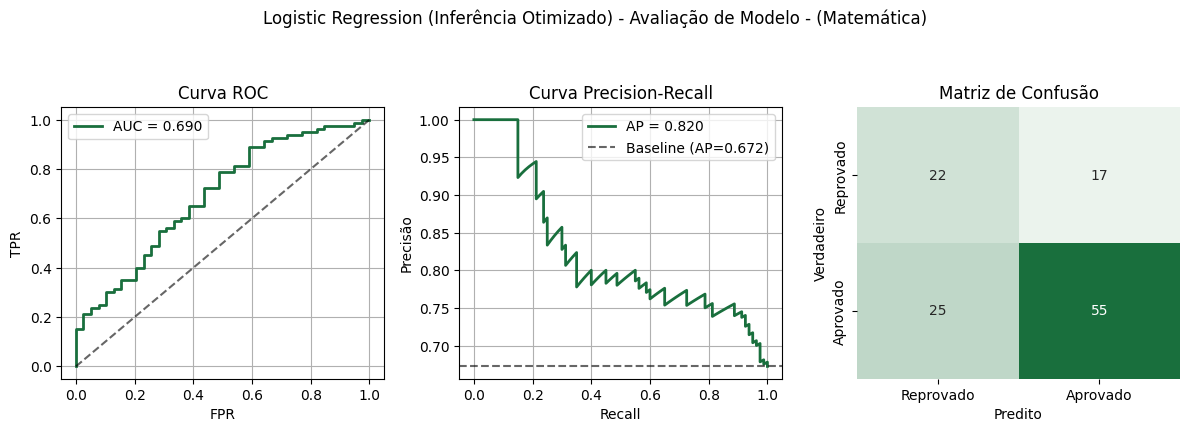


Processando modelo: AdaBoost (Inferência Otimizado)
  Avaliando AdaBoost (Inferência Otimizado) (sem otimização)...
  Gerando curvas ROC, PR e matriz de confusão (modelo base)...
Figura salva em: imagens\curvas_comparativas_models\curvas_e_matriz_AdaBoost (Inferência Otimizado)_matematica.png_matematica.png


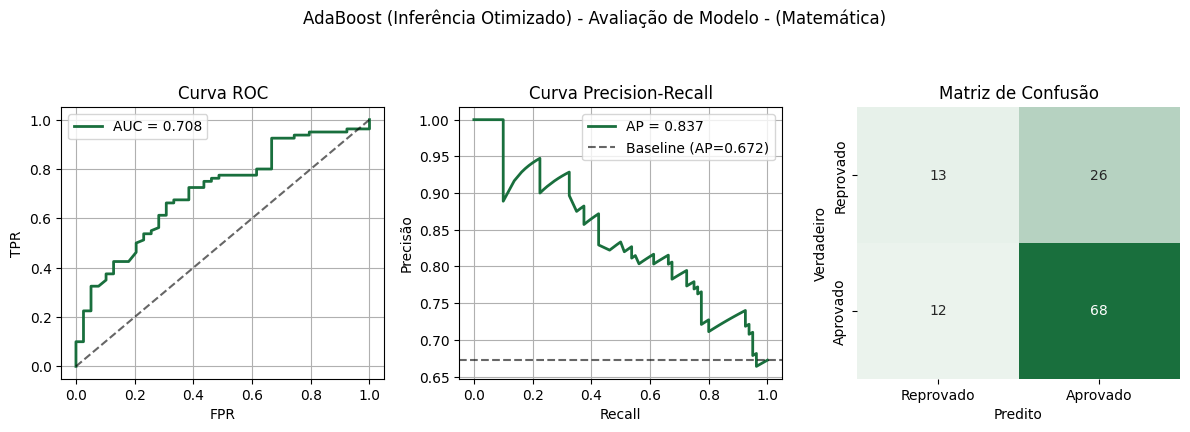

(                                              Modelo  Acurácia  Precisão(0)  \
 0  Logistic Regression (Inferência Otimizado) Sem...     0.647        0.468   
 1     AdaBoost (Inferência Otimizado) Sem Otimizacao     0.681        0.520   
 
    Precisão(1)  Recall(0)  Recall(1)  F1 Score (Reprovado)  F1 Score (Macro)  \
 0        0.764      0.564      0.688                 0.512             0.618   
 1        0.723      0.333      0.850                 0.406             0.594   
 
    AUC ROC  
 0    0.690  
 1    0.708  ,
                                               Modelo  \
 0  Logistic Regression (Inferência Otimizado) Sem...   
 1     AdaBoost (Inferência Otimizado) Sem Otimizacao   
 
    Validação Cruzada (AUC ROC)  Validação Cruzada (Acurácia)  \
 0                        0.691                         0.667   
 1                        0.675                         0.724   
 
    Validação Cruzada (Precisão(0))  Validação Cruzada (Precisão(1))  \
 0                          

In [38]:
avaliar_classificadores_binarios_otimizados(
    X_train1, y_train1,X_test1,y_test1,
    classificadores=mod_inferencia,  
    param_spaces=None, 
    usar_balanceamento=False, 
    materia='matematica', 
    salvar = True 
)


Processando modelo: Logistic Regression (Regressão Otimizado)
  Avaliando Logistic Regression (Regressão Otimizado) (sem otimização)...
  Gerando curvas ROC, PR e matriz de confusão (modelo base)...
Figura salva em: imagens\curvas_comparativas_models\curvas_e_matriz_Logistic Regression (Regressão Otimizado)_matematica.png_matematica.png


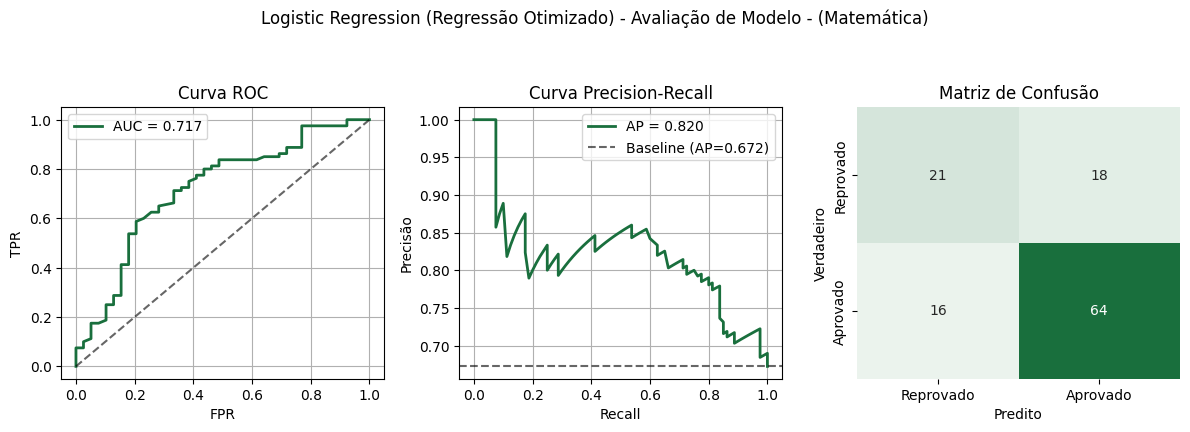


Processando modelo: Random Forest (Regressão Otimizado)
  Avaliando Random Forest (Regressão Otimizado) (sem otimização)...
  Gerando curvas ROC, PR e matriz de confusão (modelo base)...
Figura salva em: imagens\curvas_comparativas_models\curvas_e_matriz_Random Forest (Regressão Otimizado)_matematica.png_matematica.png


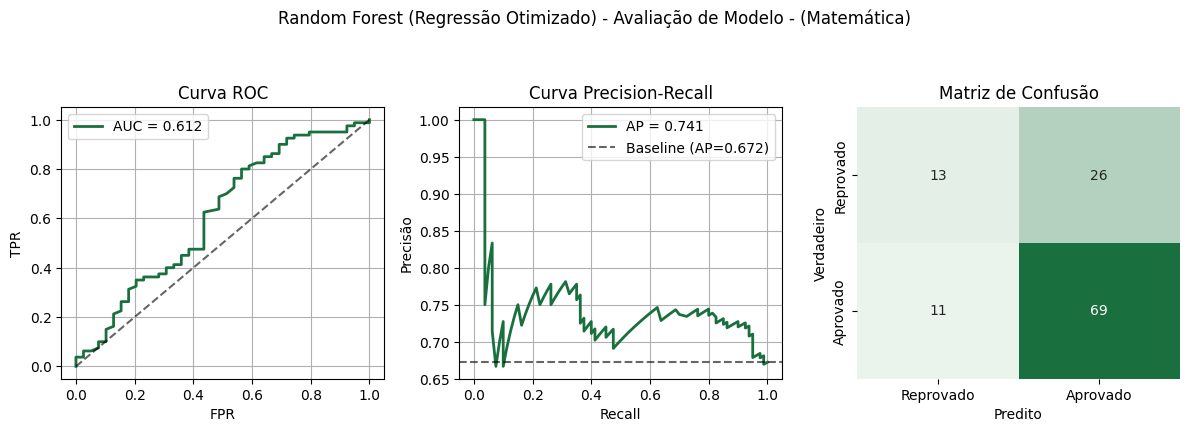

(                                              Modelo  Acurácia  Precisão(0)  \
 0  Logistic Regression (Regressão Otimizado) Sem ...     0.714        0.568   
 1  Random Forest (Regressão Otimizado) Sem Otimiz...     0.689        0.542   
 
    Precisão(1)  Recall(0)  Recall(1)  F1 Score (Reprovado)  F1 Score (Macro)  \
 0        0.780      0.538      0.800                 0.553             0.671   
 1        0.726      0.333      0.862                 0.413             0.601   
 
    AUC ROC  
 0    0.717  
 1    0.612  ,
                                               Modelo  \
 0  Logistic Regression (Regressão Otimizado) Sem ...   
 1  Random Forest (Regressão Otimizado) Sem Otimiz...   
 
    Validação Cruzada (AUC ROC)  Validação Cruzada (Acurácia)  \
 0                        0.719                         0.703   
 1                        0.632                         0.663   
 
    Validação Cruzada (Precisão(0))  Validação Cruzada (Precisão(1))  \
 0                          

In [39]:
avaliar_classificadores_binarios_otimizados(
    X_train2, y_train2,X_test2,y_test2,
    classificadores=mod_regressao,  
    param_spaces=None, 
    usar_balanceamento=False, 
    materia='matematica', 
    salvar = True 
)


Processando modelo: Logistic Regression (Inferência Otimizado)
  Avaliando Logistic Regression (Inferência Otimizado) (sem otimização)...
  Gerando curvas ROC, PR e matriz de confusão (modelo base)...
Figura salva em: imagens\curvas_comparativas_models\curvas_e_matriz_Logistic Regression (Inferência Otimizado)_matematica.png_matematica.png


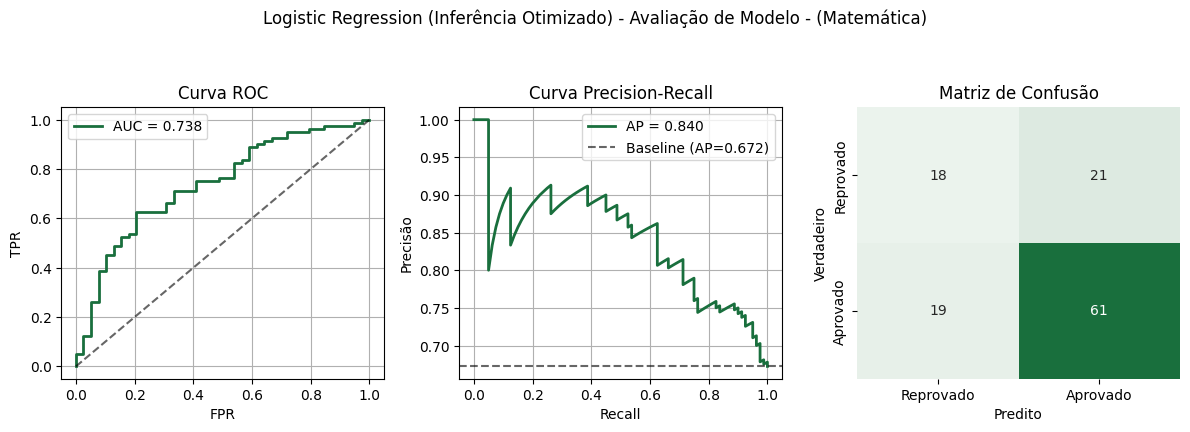


Processando modelo: AdaBoost (Inferência Otimizado)
  Avaliando AdaBoost (Inferência Otimizado) (sem otimização)...
  Gerando curvas ROC, PR e matriz de confusão (modelo base)...
Figura salva em: imagens\curvas_comparativas_models\curvas_e_matriz_AdaBoost (Inferência Otimizado)_matematica.png_matematica.png


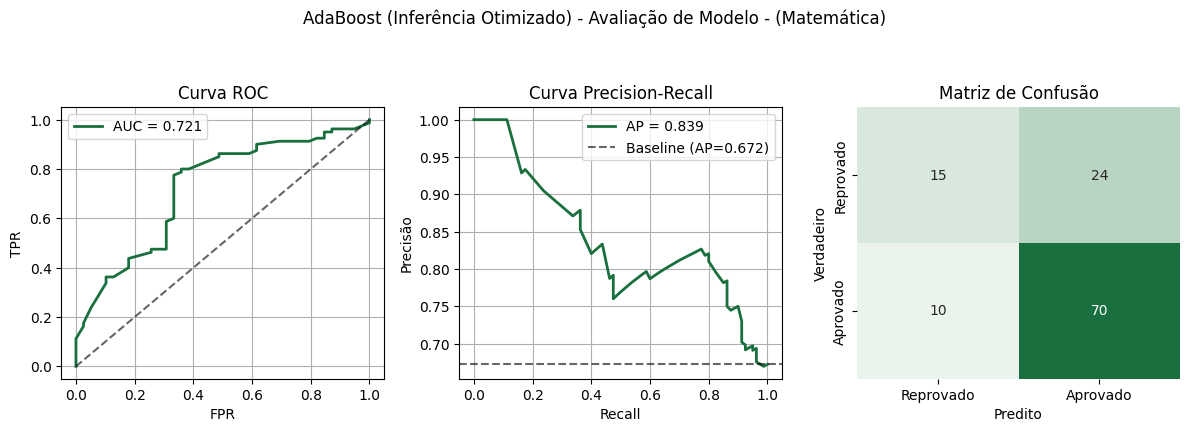

(                                              Modelo  Acurácia  Precisão(0)  \
 0  Logistic Regression (Inferência Otimizado) Sem...     0.664        0.486   
 1     AdaBoost (Inferência Otimizado) Sem Otimizacao     0.714        0.600   
 
    Precisão(1)  Recall(0)  Recall(1)  F1 Score (Reprovado)  F1 Score (Macro)  \
 0        0.744      0.462      0.762                 0.474             0.613   
 1        0.745      0.385      0.875                 0.469             0.637   
 
    AUC ROC  
 0    0.738  
 1    0.721  ,
                                               Modelo  \
 0  Logistic Regression (Inferência Otimizado) Sem...   
 1     AdaBoost (Inferência Otimizado) Sem Otimizacao   
 
    Validação Cruzada (AUC ROC)  Validação Cruzada (Acurácia)  \
 0                        0.685                         0.688   
 1                        0.701                         0.743   
 
    Validação Cruzada (Precisão(0))  Validação Cruzada (Precisão(1))  \
 0                          

In [40]:
avaliar_classificadores_binarios_otimizados(
    X_train3, y_train3,X_test3,y_test3,
    classificadores=mod_inferencia,  
    param_spaces=None, 
    usar_balanceamento=False, 
    materia='matematica', 
    salvar = True 
)

### **Síntese da Análise Visual dos 5 modelos**

- a Regressão Logística otimizada — especialmente com seleção de atributos por inferência estatística — se destacou pelo equilíbrio entre precisão, interpretabilidade e estabilidade, com taxas moderadas de erro e bom desempenho em métricas globais (AUC e AP).

- O AdaBoost apresentou as melhores curvas ROC e PR, mostrando grande capacidade de aprendizado, mas com tendência a gerar muitos falsos positivos, o que exige cuidado em contextos com impacto elevado dessas previsões.

- Já o Random Forest, apesar de sua robustez, demonstrou um recall elevado com menor AUC, sugerindo utilidade em cenários de triagem ou prevenção, onde é preferível errar pelo excesso de avisos.

De forma geral, os modelos escolhidos demonstraram consistência nos padrões de acerto, com diferenças sutis que refletem o impacto da seleção de atributos e da escolha algorítmica no equilíbrio entre sensibilidade e especificidade.

# 6. **Conclusões e Insights sobre os modelos e seus atributos**


| Atributo                    | EDA | Regressão | Inferência | Total de Seleções |
| --------------------------- | :-: | :-------: | :--------: | :---------------: |
| `reprovacoes`               |  SIM  |     SIM     |      SIM     |       **3**       |
| `interesse_ensino_superior` |  SIM  |     SIM     |      SIM     |       **3**       |
| `apoio_escolar`             |  SIM  |     SIM     |      **NÃO**     |         2         |
| `relacao_familiar`          |  SIM  |     **NÃO**     |      SIM     |         2         |
| `idade`                     |  SIM  |     SIM     |      **NÃO**     |         2         |
| `alcool_dias_uteis`         |  SIM  |     SIM     |      **NÃO**     |         2         |
| `tempo_estudo`              |  SIM  |     **NÃO**     |      SIM     |         2         |
| `escolaridade_mae`          |  SIM  |     **NÃO**     |      SIM     |         2         |
| `frequencia_saidas`         |  SIM  |     **NÃO**     |      SIM     |         2         |
| `faltas`*                    | SIM |     **NÃO**     |      SIM     |         2         |

>
> ###### *Nota: faltas foi incluída manualmente mesmo sem destaque estatístico, devido à sua relevância pedagógica evidenciada nas análises exploratórias.
>
---
- `reprovacoes` e `interesse_ensino_superior` foram as únicas variáveis presentes em todos os três métodos de seleção, evidenciando forte valor preditivo e interpretabilidade educacional.

- A presença de atributos socioeducacionais, como `apoio_escolar`, `relacao_familiar` e `escolaridade_mae`, reforça a importância do contexto familiar e de suporte ao aluno no sucesso escolar.

- O atributo `faltas`, apesar de não selecionado automaticamente por todos os métodos, foi mantido por critério pedagógico e aparece em modelos com bom desempenho, sugerindo relevância prática — ainda que sua contribuição isolada não tenha sido testada diretamente.

- Os melhores modelos, apesar de oriundos de seleções distintas, convergem em atributos com forte respaldo educacional, o que aumenta a confiança e aplicabilidade das predições no contexto da escola.

# 7. Processo realizado para obtenção dos resultados

In [41]:
# Modelos selecionados para otimização
classifiers = classificadores_globais #inserir os classificadores de interesse


parametros = {}  #inserir os param_spaces de interesse

balanceamento = False #ou True



In [ ]:
df_resultados, df_cv, best_params_df = avaliar_classificadores_binarios_otimizados(
    X_train, y_train,X_test,y_test, #adicione a numeração de acordo com a modelagem desejada
    classificadores=classifiers, #classificadores de interesse 
    param_spaces=param_spaces, #ou parametros
    usar_balanceamento=balanceamento, #ou True
    materia='matematica', #ou português
    salvar = False #True, se desejar salvar imagens
)

In [ ]:
display(df_resultados)

display(df_cv)

relatorio_ajuste = verificar_overfitting(df_resultados, df_cv)

display(relatorio_ajuste)
     

In [ ]:
# Aquisição dos hiperparametros

# Exibe todas as colunas e expande a visualização de strings
pd.set_option('display.max_colwidth', None)

best_params_df